In [29]:
from op_op.load import load_events, load_raw_calcium
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from op_op.event_ts import events_to_time_series_df
import scipy.signal
import pandas as pd
import numpy as np

In [44]:
DATA_DIR = Path(os.environ.get("DATA_DIR")) / "raw"

sns.set_context("notebook", font_scale=1.5)

In [45]:
MOUSE = "example-mouse"
SESSIONS = (
    "rm-early",
    "rm-late",
    "rdt-d1",
    "rdt-d2",
    "rdt-d3",
)
SESSION = "rdt-d1"

In [46]:
df_events = load_events(data_dir=DATA_DIR, mouse_name=MOUSE, session=SESSION)
df_ca = load_raw_calcium(data_dir=DATA_DIR, mouse_name=MOUSE, session=SESSION)

max_time = df_ca["time"].max()

In [73]:
# boxcar
kernel = scipy.signal.windows.boxcar(1)

events = ("start_time", "screen_touch_time", "reward_collection_time")
df_list = []
for event in events:
    df_list.append(
        events_to_time_series_df(
            events_array=df_events[event].values,
            event_name=event,
            total_duration=max_time,
            num_shifts_backwards=3,
            num_shifts_forwards=3,
            kernel=None,
            sampling_interval=0.1,
        ).set_index("time")
    )

df = pd.concat(df_list, axis=1)

/tmp/ipykernel_21362/1017962691.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x / 60) for x in ax.get_xticks().tolist()], fontsize=12)


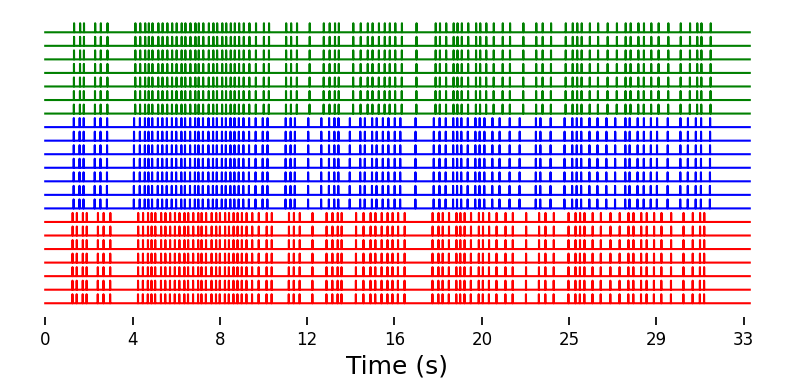

In [75]:
shifts = np.arange(-10, 11)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True)


offset = 1.5

dfp = df

COLORS = {events[0]: "red", events[1]: "blue", events[2]: "green"}
for i in range(dfp.shape[1]):
    event = list(filter(lambda x: x in dfp.columns[i], events))[0]
    ax.plot(
        dfp.index,
        dfp.iloc[:, i] + i * offset,
        color=COLORS[event],
        label=event,
    )

ax.set_xticklabels([int(x / 60) for x in ax.get_xticks().tolist()], fontsize=12)
ax.set_xlabel("Time (min)")
ax.yaxis.set_visible(False)
ax.set_xlabel("Time (s)")


sns.despine(fig=fig, left=True, bottom=True)

In [76]:
df_events = load_events(DATA_DIR, MOUSE, SESSION)
df_events = df_events.loc[lambda x: ~x.was_omission]

starts, stops = df_events[["start_time", "reward_collection_time"]].values.T

blocks = df_events["block_type"].values

/tmp/ipykernel_21362/1258379696.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


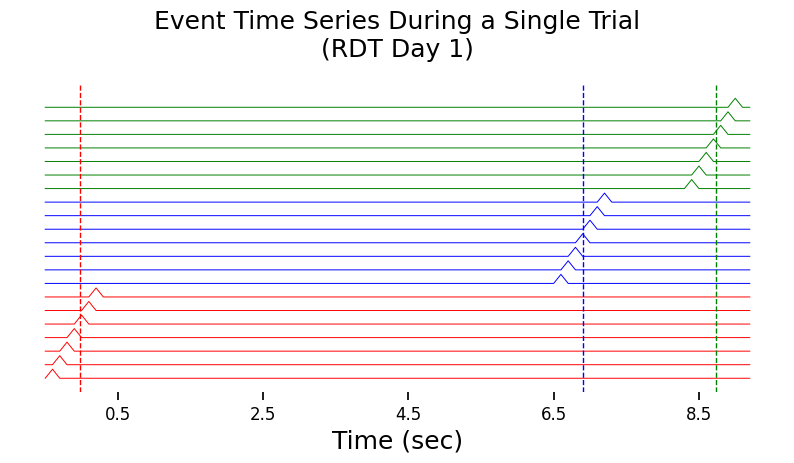

In [79]:
TRIAL = 40

dfp3 = dfp.loc[
    lambda x: (x.index > starts[TRIAL] - 0.5) & (x.index < stops[TRIAL] + 0.5)
]
event_row = df_events.iloc[TRIAL]

mouse_init = event_row["start_time"]
screen_touch_time = event_row["screen_touch_time"]
reward_collection_time = event_row["reward_collection_time"]


fig, ax = plt.subplots(1, 1, figsize=(10, 4))

offset = 1.5

COLORS = {events[0]: "red", events[1]: "blue", events[2]: "green"}
for i, neuron in enumerate(dfp3.columns):
    event = list(filter(lambda x: x in dfp.columns[i], events))[0]
    ax.plot(
        dfp3.index, dfp3[neuron] + (offset * i), alpha=1, color=COLORS[event], lw=0.7
    )

ax.axvline(mouse_init, color="red", linestyle="--", lw=1, label="Mouse Initiation")

ax.axvline(screen_touch_time, color="blue", linestyle="--", lw=1, label="Screen Touch")
ax.axvline(
    reward_collection_time,
    color="green",
    linestyle="--",
    lw=1,
    label="Reward Collection",
)

ax.set_xticklabels(
    [round(x - starts[TRIAL], 1) for x in ax.get_xticks().tolist()], fontsize=12
)

ax.set_xlabel("Time (sec)")
ax.yaxis.set_visible(False)

ax.set_title("Event Time Series During a Single Trial\n(RDT Day 1)", pad=20)

sns.despine(fig=fig, left=True, bottom=True)